- **Code Set Up**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, lagrange
from scipy.signal import chirp

# Generate a time axis and sample points
t = np.linspace(0, 10, 1000)  # Continuous time axis
sampling_t = np.linspace(0, 10, 20)  # Discrete sample times

# Original low-frequency signal (0.5 Hz sine wave)
low_freq_signal = np.sin(2 * np.pi * 0.5 * t)
# Original high-frequency signal (5 Hz sine wave)
high_freq_signal = np.sin(2 * np.pi * 5 * t)

# Piecewise linear signal for ZOH example
piecewise_signal = np.piecewise(t, [t < 3, (t >= 3) & (t < 7), t >= 7], [1, -1, 0])

# Sharp-edged signal for Cubic Spline and Lagrange cons
sharp_signal = np.piecewise(t, [t < 3, (t >= 3) & (t < 7), t >= 7], [0, 1, 0])

# Define a function to demonstrate each method
def plot_signal_reconstruction(original, sample_t, sample_vals, reconstructed, title, t):
    plt.figure(figsize=(10, 6))
    plt.plot(t, original, label='Original Signal', color='blue', alpha=0.5)
    plt.scatter(sample_t, sample_vals, color='red', label='Sampled Signal')
    plt.plot(t, reconstructed, label='Reconstructed Signal', color='green', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

### 1. **Whittaker-Shannon Interpolation (Sinc Interpolation)**
This is the ideal reconstruction method for band-limited signals that have been sampled at or above the Nyquist rate.
- **Genereal Implementation**

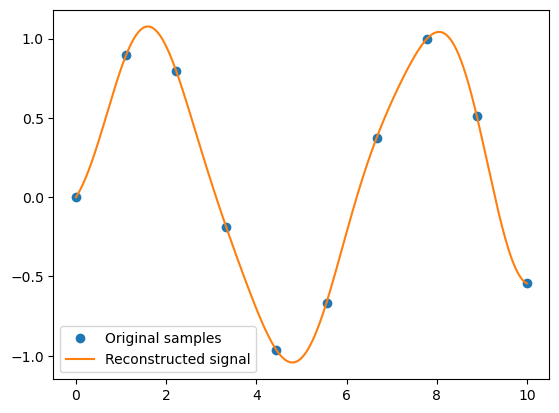

In [2]:
def sinc_interp(x, s, t):
    """
    Sinc interpolation of a sampled signal.
    x: sample positions (sampling_t)
    s: sample values (sampled_signal)
    t: target positions (continuous time for reconstruction)
    """
    # Calculate the sinc interpolation with proper normalization
    T = x[1] - x[0]  # Sampling period
    return np.array([np.sum(s * np.sinc((t_i - x) / T)) for t_i in t])

# Example usage
x = np.linspace(0, 10, 10)    # Sampled times
s = np.sin(x)              # Sampled signal

s_interp = sinc_interp(x, s, t)

plt.plot(x, s, 'o', label='Original samples')
plt.plot(t, s_interp, '-', label='Reconstructed signal')
plt.legend()
plt.show()

- **Sinc Function**

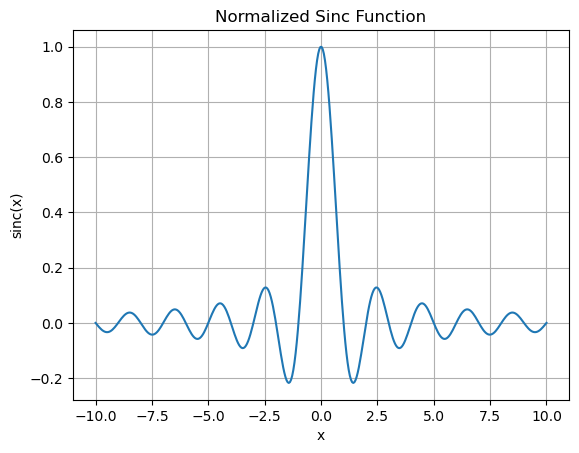

In [3]:
# Create an array of values
x = np.linspace(-10, 10, 400)
y = np.sinc(x)

# Plotting the sinc function
plt.plot(x, y)
plt.title('Normalized Sinc Function')
plt.xlabel('x')
plt.ylabel('sinc(x)')
plt.grid()
plt.show()

- **Pros:**
    - **Perfect reconstruction**: It provides exact recovery of the original signal, assuming ideal conditions like no noise and perfect sampling.
    - **Foundation of digital signal processing**: Based on the sampling theorem, it guarantees perfect recovery for band-limited signals.
    - **Example**:
        - We will generate a low-frequency sinusoidal signal, which should be perfectly reconstructed by sinc interpolation because it is band-limited and satisfies the Nyquist rate.

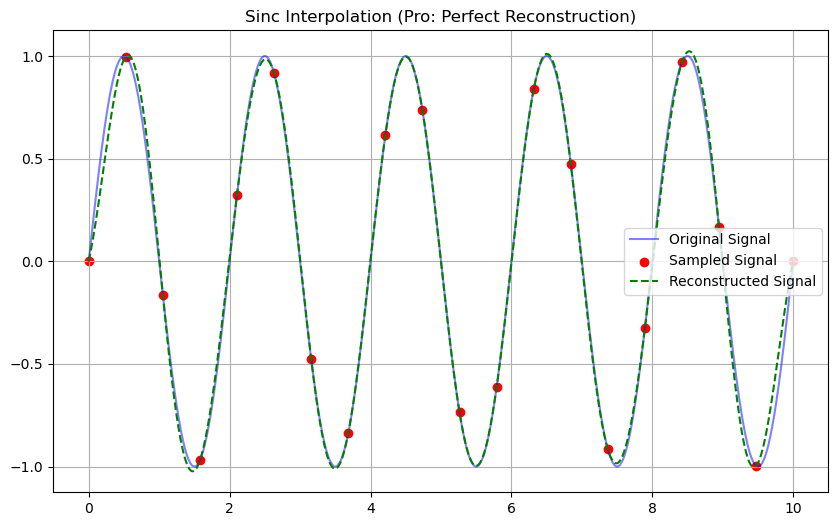

In [4]:
def sinc_interp_example():
    sampled_signal = np.sin(2 * np.pi * 0.5 * sampling_t)
    reconstructed_signal = sinc_interp(sampling_t, sampled_signal, t)

    plot_signal_reconstruction(low_freq_signal, sampling_t, sampled_signal, reconstructed_signal, 
    "Sinc Interpolation (Pro: Perfect Reconstruction)", t)

sinc_interp_example()

- **Cons:**
    - **Computational complexity**: The sinc function is computationally expensive because it decays slowly, requiring infinite samples for perfect reconstruction.
    - **Prone to numerical issues**: In practical systems, truncating (using finite number of sinc terms) the sinc function can introduce artifacts such as Gibbs ringing.
    - **InAccurate for small datasets with irregularly spaced samples**
    - **Example**:
        - We’ll add high-frequency components (high relatively to sampling rate) to the signal and truncate the sinc function to show the Gibbs phenomenon (ringing) around sharp transitions due to the limited number of samples (**undersampling**).
        - Sampling square wave signals with sharp edges

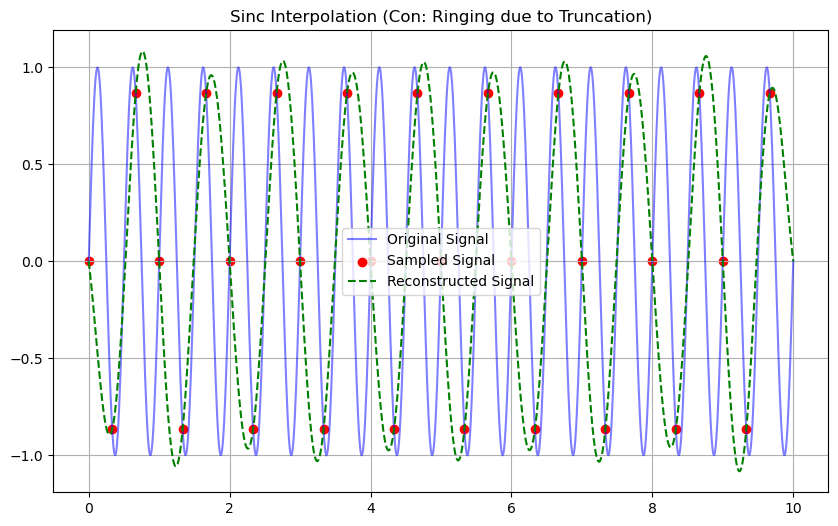

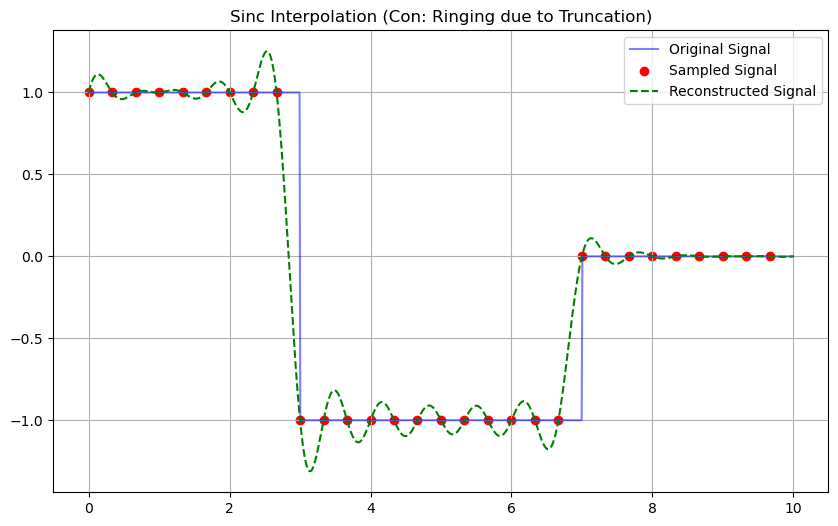

In [6]:
def sinc_interp_ringing_example():
    # Aliasing Due to Undersampling
    t = np.linspace(0, 10, 1000)
    sampling_rate = 3  # Sample at 5 Hz (undersampling)
    sampling_t = np.arange(0, 10, 1/sampling_rate)
    high_freq_signal = np.sin(2 * np.pi * 2 * t)

    sampled_signal_high_freq = np.sin(2 * np.pi * 2 * sampling_t)  # High frequency
    reconstructed_signal_high_freq = sinc_interp(sampling_t, sampled_signal_high_freq, t)

    plot_signal_reconstruction(high_freq_signal, sampling_t, sampled_signal_high_freq, reconstructed_signal_high_freq,
                            "Sinc Interpolation (Con: Ringing due to Truncation)", t)

    # ringing phenomenon due to sharp edges
    sampled_signal_sharp_edge = np.piecewise(sampling_t, [sampling_t < 3, (sampling_t >= 3) & (sampling_t < 7), sampling_t >= 7], [1, -1, 0])
    reconstructed_signal_sharp_edge = sinc_interp(sampling_t, sampled_signal_sharp_edge, t)

    plot_signal_reconstruction(piecewise_signal, sampling_t, sampled_signal_sharp_edge, reconstructed_signal_sharp_edge, 
                            "Sinc Interpolation (Con: Ringing due to Truncation)", t)

sinc_interp_ringing_example()

-
    -
        - Irregularly spaced samples

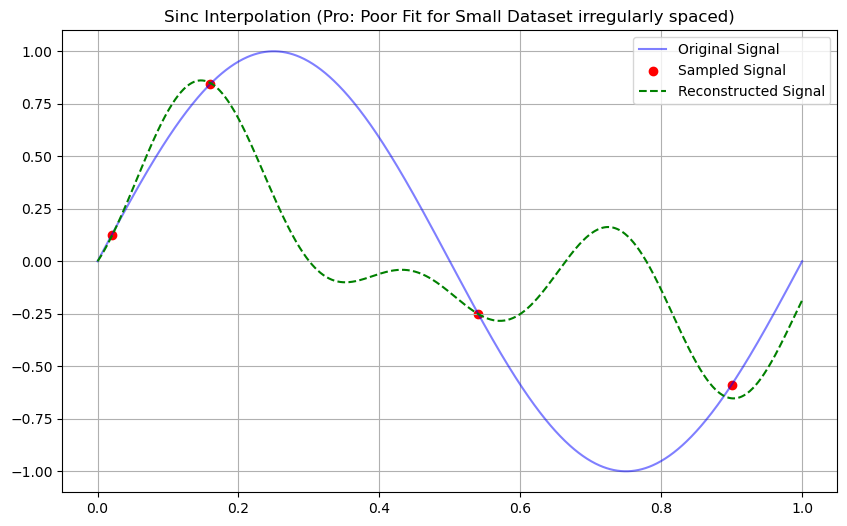

In [7]:
x_samples = np.array([0.02, 0.16, 0.54, 0.9]) 
# x_samples = np.array([0.0, 0.25, 0.5, 0.75])  
y_samples = np.sin(2 * np.pi * x_samples)  

x_interp = np.linspace(0, 1, 1000)  

plot_signal_reconstruction(np.sin(2 * np.pi * x_interp), x_samples, y_samples, sinc_interp(x_samples, y_samples, x_interp), 
                            "Sinc Interpolation (Pro: Poor Fit for Small Dataset irregularly spaced)", x_interp)

### 2. **Zero-Order Hold (ZOH) Interpolation**
ZOH is a basic reconstruction technique that holds each sample constant until the next sample. It is often used in systems where the signal is sampled at regular intervals and needs to be reconstructed in a step-like fashion.

- **General Python Implementation**:

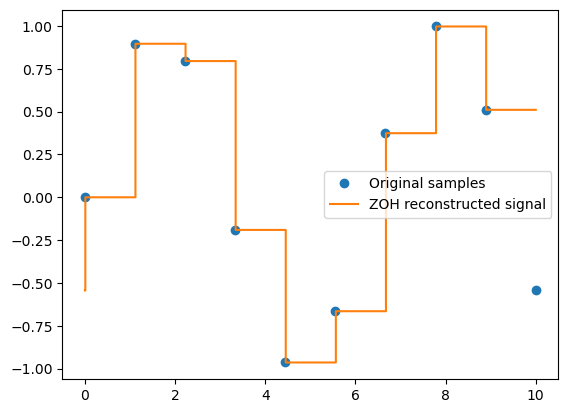

In [8]:
def zero_order_hold(x, s, t):
    """Zero-order hold interpolation."""
    s_interp = np.zeros_like(t)
    for i, t_i in enumerate(t):
        idx = np.searchsorted(x, t_i) - 1
        s_interp[i] = s[idx]
    return s_interp

# Example usage
x = np.linspace(0, 10, 10)    # Sampled times
s = np.sin(x)              # Sampled signal
s_interp = zero_order_hold(x, s, t)

plt.plot(x, s, 'o', label='Original samples')
plt.step(t, s_interp, label='ZOH reconstructed signal', where='post')
plt.legend()
plt.show()

- **Pros:**
    - **Simplicity**: Very easy to implement and computationally efficient.
    - **Low latency**: Quick to execute, especially useful in real-time systems.
    - **Example**:
        - For a slowly varying signal, ZOH can offer a simple reconstruction that works reasonably well. We’ll use a piecewise linear signal with small changes to show this.

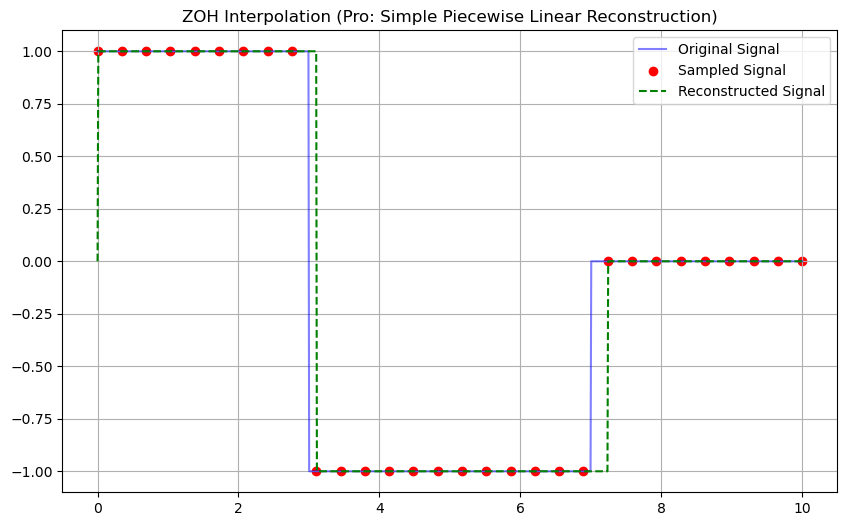

In [9]:
def zoh_example():
    sampling_t = np.linspace(0, 10, 30)
    sampled_signal = np.piecewise(sampling_t, [sampling_t < 3, (sampling_t >= 3) & (sampling_t < 7), sampling_t >= 7], [1, -1, 0])
    reconstructed_signal = zero_order_hold(sampling_t, sampled_signal, t)

    plot_signal_reconstruction(piecewise_signal, sampling_t, sampled_signal, reconstructed_signal, 
                               "ZOH Interpolation (Pro: Simple Piecewise Linear Reconstruction)", t)
zoh_example()

- **Cons:**
    - **Poor accuracy**: Does not capture smooth transitions in the original signal, which may result in a blocky appearance.
    - **Introduces high-frequency distortion**: This method can introduce aliasing and loss of high-frequency components, making it unsuitable for high-quality signal recovery.
    - **Example**:
        - When reconstructing a smooth signal (e.g., a high-frequency sinusoid), ZOH will produce a blocky, step-like appearance that highlights its low accuracy and the introduction of high-frequency distortion.

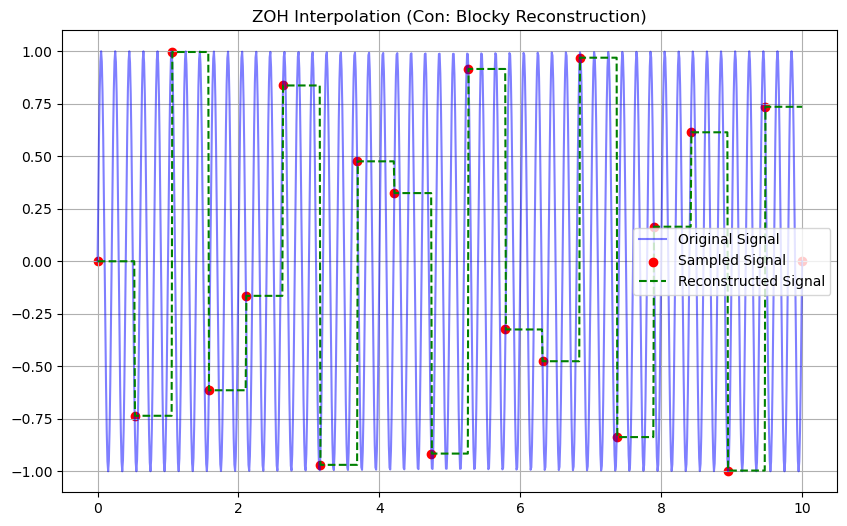

In [10]:
def zoh_con_example():
    sampled_signal = np.sin(2 * np.pi * 5 * sampling_t)  # High frequency
    reconstructed_signal = zero_order_hold(sampling_t, sampled_signal, t)

    plot_signal_reconstruction(high_freq_signal, sampling_t, sampled_signal, reconstructed_signal, 
                               "ZOH Interpolation (Con: Blocky Reconstruction)", t)

zoh_con_example()

### 3. **Linear Interpolation**
This method connects the sample points with straight lines, which provides a continuous approximation of the original signal.

**General Python Implementation**:

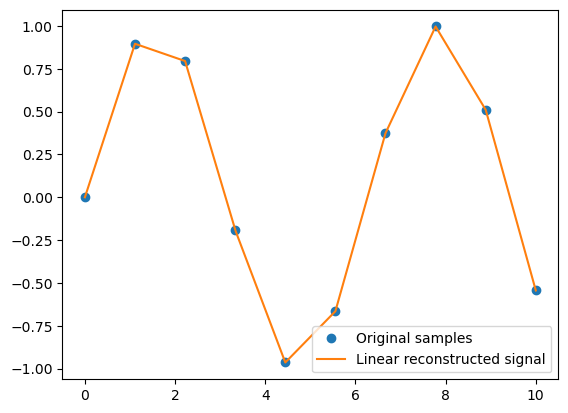

In [11]:
def linear_interp(x, s, t):
    """Linear interpolation of a signal."""
    return np.interp(t, x, s)

# Example usage
s_interp = linear_interp(x, s, t)

plt.plot(x, s, 'o', label='Original samples')
plt.plot(t, s_interp, '-', label='Linear reconstructed signal')
plt.legend()
plt.show()

- **Pros:**
    - **Simplicity**: Easy to implement and computationally light.
    - **Better accuracy than ZOH**: It provides smoother transitions than zero-order hold interpolation.
    - **Example**:
        - For a linear or slowly varying signal, linear interpolation will offer a smooth approximation with reasonable accuracy.

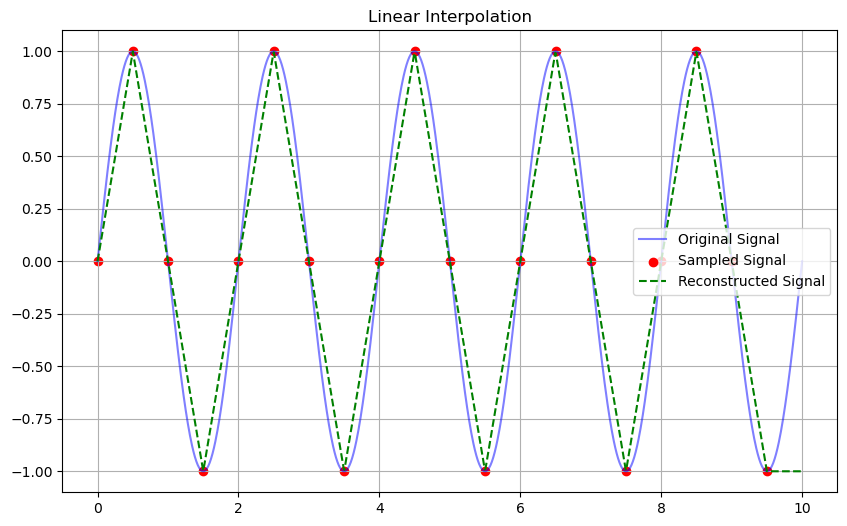

In [12]:
def linear_interp_example():
    sampling_t = np.arange(0, 10, 1 / 2)
    sampled_signal = np.sin(2 * np.pi * 0.5 * sampling_t)  # Low frequency
    reconstructed_signal = np.interp(t, sampling_t, sampled_signal)

    plot_signal_reconstruction(low_freq_signal, sampling_t, sampled_signal, reconstructed_signal, 
                               "Linear Interpolation", t)

linear_interp_example()

- **Cons:**
    - **Not smooth**: The derivative of the reconstructed signal is not continuous, which may cause problems in some applications, especially those requiring smooth signal recovery.
    - **Still introduces errors**: This method cannot perfectly reconstruct signals with high-frequency components.
    - **Example:**
        - When applied to a higher frequency sinusoidal signal, linear interpolation will show sharp corners at each sample, resulting in non-smooth transitions that do not capture the signal well.

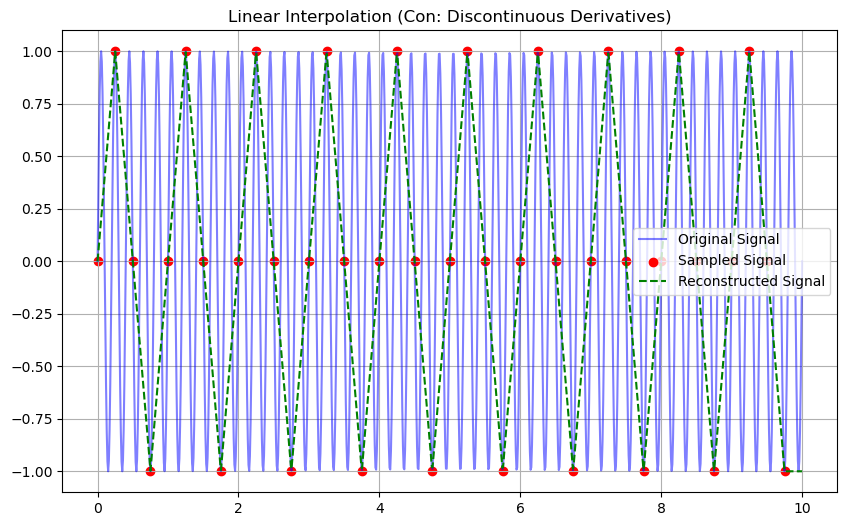

In [13]:
def linear_interp_con_example():
    sampling_t = np.arange(0, 10, 1 / 4)
    sampled_signal = np.sin(2 * np.pi * 5 * sampling_t)  # High frequency
    reconstructed_signal = np.interp(t, sampling_t, sampled_signal)

    plot_signal_reconstruction(high_freq_signal, sampling_t, sampled_signal, reconstructed_signal, 
                               "Linear Interpolation (Con: Discontinuous Derivatives)", t)

linear_interp_con_example()

### 4. **Cubic Spline Interpolation**
Cubic spline interpolation constructs a **smooth** curve by fitting piecewise cubic polynomials between the sample points.

**General Python Implementation**:

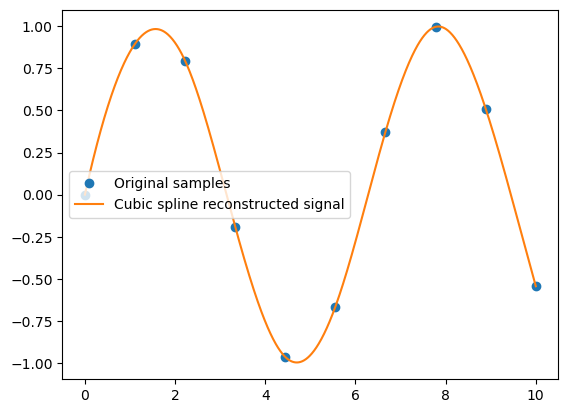

In [14]:
from scipy.interpolate import CubicSpline

def cubic_spline_interp(x, s, t):
    """Cubic spline interpolation of a signal."""
    cs = CubicSpline(x, s)
    return cs(t)

# Example usage
s_interp = cubic_spline_interp(x, s, t)

plt.plot(x, s, 'o', label='Original samples')
plt.plot(t, s_interp, '-', label='Cubic spline reconstructed signal')
plt.legend()
plt.show()

- **Pros:**
    - **Smooth reconstruction**: Provides continuous first and second derivatives, which makes it ideal for smooth signal reconstruction.
    - **Accurate**: Offers much better accuracy than linear interpolation, especially for smooth signals with continuous derivatives.
    - **Example**:
        - For a smooth signal, cubic spline interpolation will provide a continuous and smooth curve, even when the original samples are sparse.

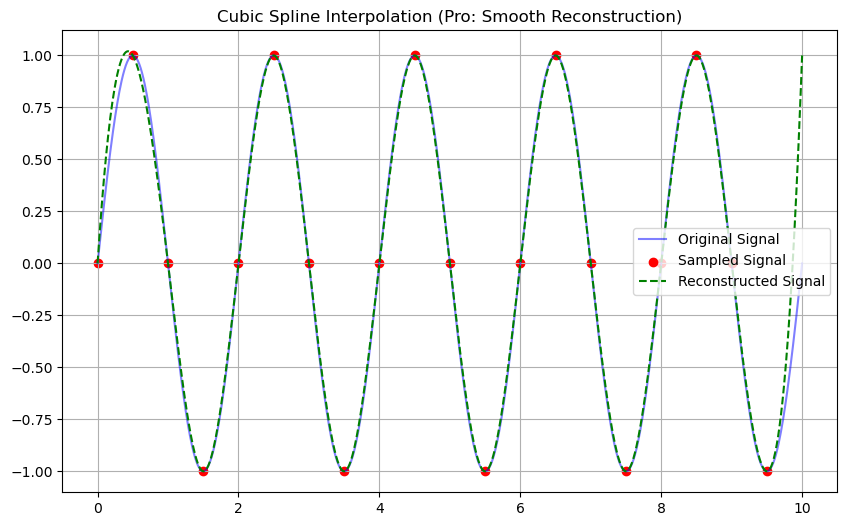

In [15]:
def cubic_spline_interp_example():
    sampling_t = np.arange(0, 10, 1 / 2)
    cs = CubicSpline(sampling_t, np.sin(2 * np.pi * 0.5 * sampling_t))
    reconstructed_signal = cs(t)

    plot_signal_reconstruction(low_freq_signal, sampling_t, np.sin(2 * np.pi * 0.5 * sampling_t), reconstructed_signal, 
                               "Cubic Spline Interpolation (Pro: Smooth Reconstruction)", t)
cubic_spline_interp_example()

- **Cons:**
    - **More complex**: Higher computational cost compared to linear interpolation or zero-order hold.
    - **Overfitting risk**: In some cases, it may introduce unwanted <u>oscillations</u> in the reconstructed signal.
    - **Example**:
        - Cubic spline interpolation may introduce oscillations (overfitting) in cases where the signal has sharp transitions or is not smooth. We will generate a signal with sharp edges to demonstrate this.

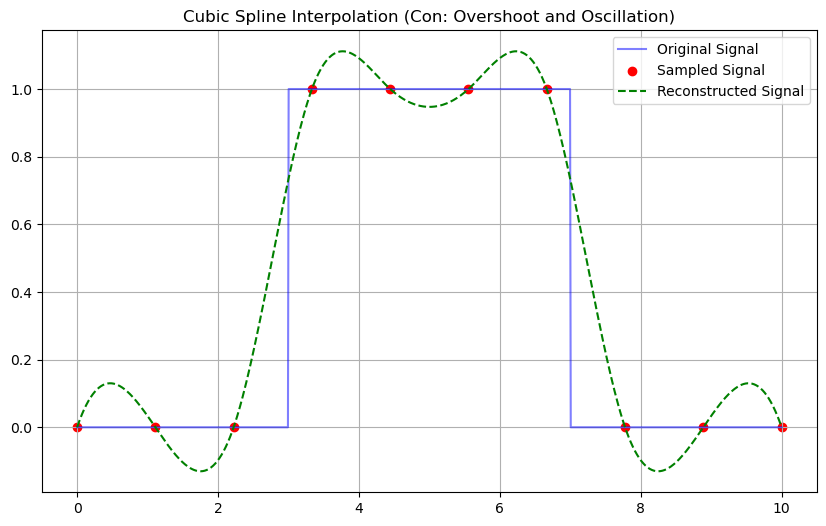

In [16]:
def cubic_spline_overshoot_example():
    # sampling_t = np.arange(0, 10, 1 / 4)
    sampling_rate = 1
    sample_points = np.linspace(0, len(t) - 1, sampling_rate * 10).astype(int)
    sampled_time = t[sample_points]
    sampled_signal = sharp_signal[sample_points]

    cs = CubicSpline(sampled_time, sampled_signal)
    reconstructed_signal = cs(t)

    plot_signal_reconstruction(sharp_signal, sampled_time, sampled_signal, reconstructed_signal, 
                               "Cubic Spline Interpolation (Con: Overshoot and Oscillation)", t)

cubic_spline_overshoot_example()

### 5. **Lagrange Interpolation**
Lagrange interpolation is a polynomial interpolation technique where a polynomial is fit to the entire dataset.

**General Python Implementation**:

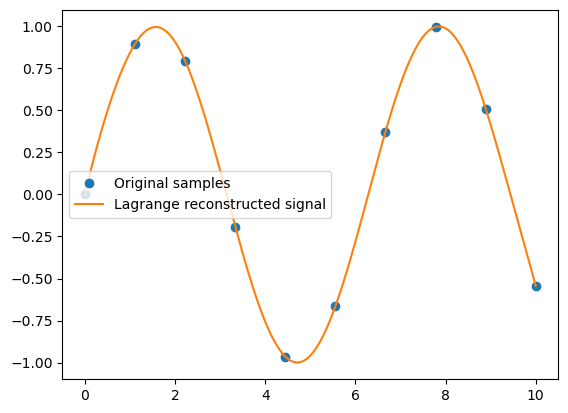

In [17]:
from scipy.interpolate import lagrange

def lagrange_interp(x, s, t):
    """Lagrange interpolation of a signal."""
    poly = lagrange(x, s)
    return poly(t)

# Example usage
s_interp = lagrange_interp(x, s, t)

plt.plot(x, s, 'o', label='Original samples')
plt.plot(t, s_interp, '-', label='Lagrange reconstructed signal')
plt.legend()
plt.show()

- **Pros:**
    - **Flexibility**: Works well for irregularly spaced data points.
    - **Accurate for <u>small datasets</u>**: Provides exact results when interpolating a small number of samples.
    - **Example:**
        - For a small dataset with irregularly spaced points, Lagrange interpolation can perfectly fit the samples. We will use a small set of irregularly spaced samples to demonstrate this.

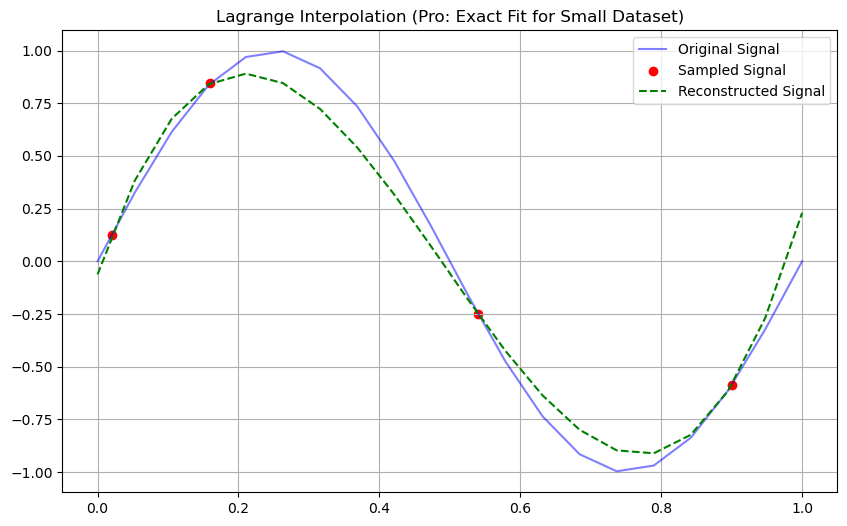

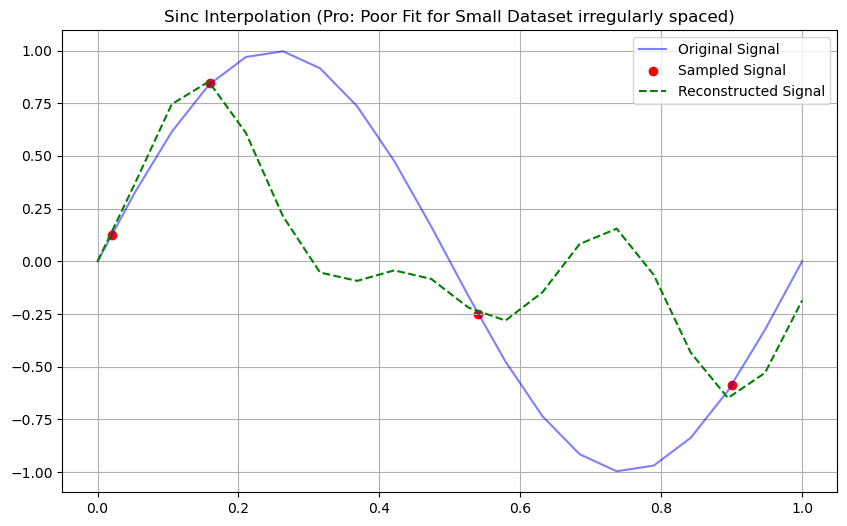

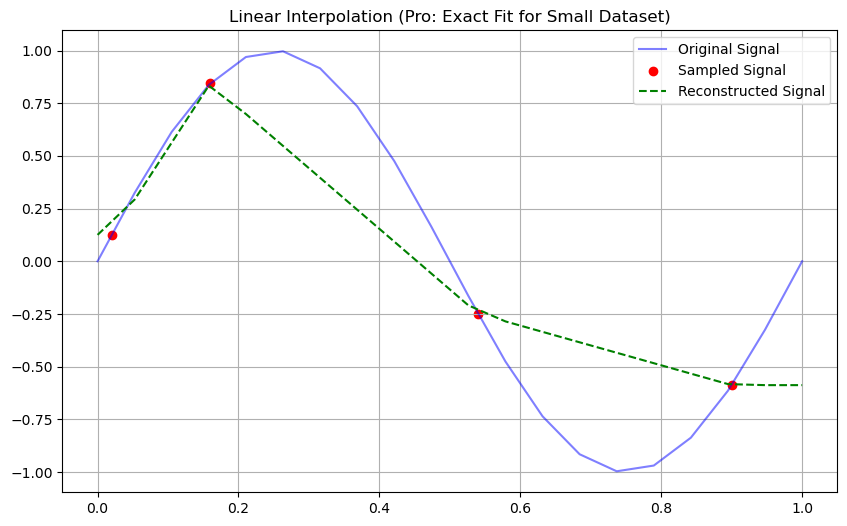

In [18]:
def lagrange_interp_example():
    x_samples = np.array([0.02, 0.16, 0.54, 0.9]) 
    # x_samples = np.array([0.0, 0.25, 0.5, 0.75])
    # x_samples = np.array([0.02, 0.1, 0.5, 0.9])   
    y_samples = np.sin(2 * np.pi * x_samples)  

    x_interp = np.linspace(0, 1, 20)  

    plot_signal_reconstruction(np.sin(2 * np.pi * x_interp), x_samples, y_samples, lagrange_interp(x_samples, y_samples, x_interp), 
                                "Lagrange Interpolation (Pro: Exact Fit for Small Dataset)", x_interp)

    plot_signal_reconstruction(np.sin(2 * np.pi * x_interp), x_samples, y_samples, sinc_interp(x_samples, y_samples, x_interp), 
                                "Sinc Interpolation (Pro: Poor Fit for Small Dataset irregularly spaced)", x_interp)  

    plot_signal_reconstruction(np.sin(2 * np.pi * x_interp), x_samples, y_samples, linear_interp(x_samples, y_samples, x_interp), 
                                "Linear Interpolation (Pro: Exact Fit for Small Dataset)", x_interp)                                                          

lagrange_interp_example()

- **Cons:**
    - **Prone to oscillations**: For large datasets, it can lead to the Runge phenomenon (large oscillations between points).
    - **High complexity**: Computationally intensive for large datasets.
    - **Example**:
        - When dealing with many points or higher frequencies, Lagrange interpolation can lead to large oscillations between points, known as the Runge phenomenon. We’ll use a high-frequency signal with many points to illustrate this issue.

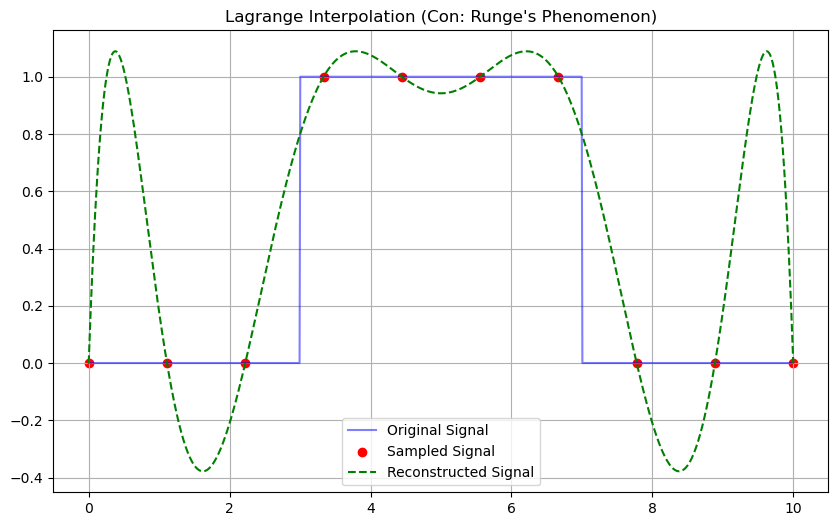

In [19]:
def lagrange_runge_example():
    sampling_rate = 1
    sample_points = np.linspace(0, len(t) - 1, sampling_rate * 10).astype(int)
    sampled_time = t[sample_points]
    sampled_signal = sharp_signal[sample_points]
    
    poly = lagrange(sampled_time, sampled_signal)
    reconstructed_signal = poly(t)

    plot_signal_reconstruction(sharp_signal, sampled_time, sampled_signal, reconstructed_signal, 
                               "Lagrange Interpolation (Con: Runge's Phenomenon)", t)

lagrange_runge_example()                    

### Summary Table:

| Method                      | Pros                                            | Cons                                                      | Use Cases                                  |
|------------------------------|-------------------------------------------------|-----------------------------------------------------------|--------------------------------------------|
| **Whittaker-Shannon (Sinc)**  | Perfect reconstruction under ideal conditions   | Computationally expensive, numerical issues                | High-accuracy DSP, theoretical applications|
| **Zero-Order Hold (ZOH)**     | Very simple, low latency                        | Low accuracy, introduces aliasing                          | Real-time systems, embedded control        |
| **Linear Interpolation**      | Simple, better than ZOH                         | Not smooth, still introduces errors                        | Moderate-quality applications              |
| **Cubic Spline**              | Smooth, high accuracy                           | Higher computational cost, possible overfitting            | High-quality reconstruction, image processing |
| **Lagrange Interpolation**    | Flexible, exact for small datasets (small freqs)              | Prone to oscillations with many points, computationally heavy| Small datasets, irregularly spaced data    |


- Irregularly spaced samples are well reconstructed by **lagrange** & **cubic** spline interpolation